In [1]:
import re
import pandas as pd
from bs4 import BeautifulSoup
from bs4.element import Comment
import urllib.request
import requests
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher
from spacy.tokens import Span

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

In [2]:
def tag_visible(element):
    if element.parent.name in ['style', 'script', 'head', 'title', 'meta', '[document]']:
        return False
    if isinstance(element, Comment):
        return False
    return True

def text_from_html(body):
    soup = BeautifulSoup(body, 'html.parser')
    texts = soup.findAll(text=True)
    visible_texts = filter(tag_visible, texts)
    return u" ".join(t.strip() for t in visible_texts)

In [3]:
html = urllib.request.urlopen('https://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2019/10/wiki_sentences_v2.csv')
print(text_from_html(html))

In [4]:
text_from_html(html)

''

In [5]:
url = "https://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2019/10/wiki_sentences_v2.csv"
html = urllib.request.urlopen(url).read()
soup = BeautifulSoup(html)

# kill all script and style elements
for script in soup(["script", "style"]):
    script.extract()    # rip it out

# get text
text = soup.get_text()

# break into lines and remove leading and trailing space on each
lines = (line.strip() for line in text.splitlines())
# break multi-headlines into a line each
chunks = (phrase.strip() for line in lines for phrase in line.split("  "))
# drop blank lines
df = '\n'.join(chunk for chunk in chunks if chunk)

print(df.encode('utf-8'))

b'sentence\n"confused and frustrated, connie decides to leave on her own."\n"later, a woman\xe2\x80\x99s scream is heard in the distance."\nchristian is then paralyzed by an elder.\nthe temple is set on fire.\n"outside, the cult wails with him."\nit\'s a parable of a woman\'s religious awakening\xe2\x80\x94\n"c. mackenzie, and craig vincent joined the cast."\n"later, craig di francia and action bronson were revealed to have joined the cast."\nsebastian maniscalco and paul ben-victor were later revealed as being part of the cast.\nwe just tried to make the film.\nwe went through all these tests and things\nm global was also circling to bid for the film\'s international sales rights.\ncanadian musician robbie robertson supervised the soundtrack.\nit features both original and existing music tracks.\nit is the worst reviewed film in the franchise.\nbut she injures quicksilver and accidentally kills mystique before flying away.\nmilitary forces tasked with her arrest.\nthe train is attacke

In [6]:
# from io import StringIO

# df = pd.read_csv(text, sep='')

In [7]:
df = pd.DataFrame([x.split(';') for x in text.split('\n')])
df.head()

,0,1,2
0,sentence,None,None
1,"""confused and frustrated, connie decides to leave on her own.""",None,None
2,"""later, a woman’s scream is heard in the distance.""",None,None
3,christian is then paralyzed by an elder.,None,None
4,the temple is set on fire.,None,None


In [8]:
col = [1, 2]
df.drop(col, 1, inplace=True)

In [9]:
df = df.iloc[1:]
df.reset_index(inplace=True)
df.head()

,index,0
0,1,"""confused and frustrated, connie decides to leave on her own."""
1,2,"""later, a woman’s scream is heard in the distance."""
2,3,christian is then paralyzed by an elder.
3,4,the temple is set on fire.
4,5,"""outside, the cult wails with him."""


In [10]:
df.dropna()
df.drop('index', axis=1, inplace=True)

In [11]:
df.shape

(4420, 1)

In [12]:
df.columns = ['sentence']


In [13]:
df['sentence'].drop_duplicates()

0                                                   "confused and frustrated, connie decides to leave on her own."
1                                                              "later, a woman’s scream is heard in the distance."
2                                                                         christian is then paralyzed by an elder.
3                                                                                       the temple is set on fire.
4                                                                              "outside, the cult wails with him."
                                                           ...                                                    
4414       "confidencial also responded negatively, calling the film a barren drama, unsubtle and self-indulgent."
4415                                                 and le parisien gave the film their highest five-star rating.
4416    "the museum collection includes 37,000 film titles, 60,000 posters, 700,

In [14]:
df.drop(df[df.sentence == ""].index, inplace=True)

In [15]:
# df.loc[df['sentence'] == ""]

In [16]:
doc = nlp('the drawdown process is governed by astm standard d823')

for tok in doc:
    print(tok.text, '...', tok.dep_)

the ... det
drawdown ... amod
process ... nsubjpass
is ... auxpass
governed ... ROOT
by ... agent
astm ... compound
standard ... pobj
d823 ... punct


In [17]:
def get_entities(sent):
    ent1 = ""
    ent2 = ""
    
    prv_tok_dep = ""
    prv_tok_text = ""
    
    prefix = ""
    modifier = ""
    
    for tok in nlp(sent):
        if tok.dep_ != 'punct':
            if tok.dep_ == 'compound':
                prefix = tok.text
                if prv_tok_dep == 'compound':
                    prefix = prv_tok_text + " " + tok.text
                    
                    
        if tok.dep_.endswith('mod') == True:
            modifier = tok.text
            
            if prv_tok_dep == 'compound':
                modifier = prv_tok_text + ' ' + tok.text
                
                
                
        if tok.dep_.find('subj') == True:
            ent1 = modifier + ' ' + prefix + ' ' + tok.text
            prefix = ""
            modifier = ""
            prv_tok_dep = ""
            prv_tok_text = ""
            
            
        if tok.dep_.find('obj') == True:
            ent2 = modifier + ' ' + prefix + ' ' + tok.text
            
            
        prv_tok_dep = tok.dep_
        prv_tok_text = tok.text
        
        
    return [ent1.strip(), ent2.strip()]
        

In [18]:
get_entities('the film has 200 patents')

['film', '200  patents']

In [19]:
entity_pairs = []

for i in tqdm(df['sentence']):
    entity_pairs.append(get_entities(i))

100%|██████████| 4415/4415 [00:38<00:00, 113.57it/s]


In [20]:
entity_pairs[10:20]

[['we', 'tests'],
 ['m global', 'international sales rights'],
 ['canadian musician robbie robertson', 'soundtrack'],
 ['it', 'original music tracks'],
 ['it', 'reviewed  franchise'],
 ['she', 'quicksilver  mystique'],
 ['military  forces', 'arrest'],
 ['train', 'vuk'],
 ['kota eberhardt', 'selene  gallio'],
 ['singer', 'men']]

In [21]:
def get_relation(sent):
    
    doc = nlp(sent)
    matcher = Matcher(nlp.vocab)
    
    pattern =[{'DEP': 'ROOT'},
             {'DEP': 'prep', 'OP': "?"},
             {'DEP': 'agent', 'OP': "?"},
             {'POS': 'ADJ', 'OP': "?"}]
    
    matcher.add('matching)_1', None, pattern)
    
    matches = matcher(doc)
    k = len(matches)-1
    
    span = doc[matches[k][1]:matches[k][2]]
    
    return(span.text)

In [22]:
get_relation('Sarah completed the task')

'completed'

In [23]:
relations =[get_relation(i) for i in tqdm(df['sentence'])]



100%|██████████| 4415/4415 [00:40<00:00, 108.06it/s]


In [24]:
df.head(187)

,sentence
0,"""confused and frustrated, connie decides to leave on her own."""
1,"""later, a woman’s scream is heard in the distance."""
2,christian is then paralyzed by an elder.
3,the temple is set on fire.
4,"""outside, the cult wails with him."""
...,...
182,whishaw left the project seven months later.
183,i never ceased to be astonished by this man.
184,discussions began about replacing him.
185,fletcher received an executive producer credit.


In [25]:
pd.Series(relations).value_counts()[:50]

is               353
was              285
"                 98
released on       80
are               72
were              65
include           63
's                40
released          36
became            32
composed by       28
have              27
has               27
become            27
released in       25
included          20
called            20
considered        18
made              18
used              17
had               17
be                17
scheduled         17
been              16
produced          16
directed by       14
received          14
set               14
hired             14
introduced in     13
went              13
sold              12
wanted            12
wrote             12
produced by       12
written by        12
won               11
began             10
began in          10
gave              10
cast as           10
produced in        9
includes           9
stars              9
shot in            9
opened             9
directed           9
reported     

In [26]:
source = [i[0] for i in entity_pairs]

target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source': source, 'target': target, 'edge': relations})

In [27]:
G = nx.from_pandas_edgelist(kg_df, 'source', 'target',
                           edge_attr=True, create_using=nx.MultiGraph())

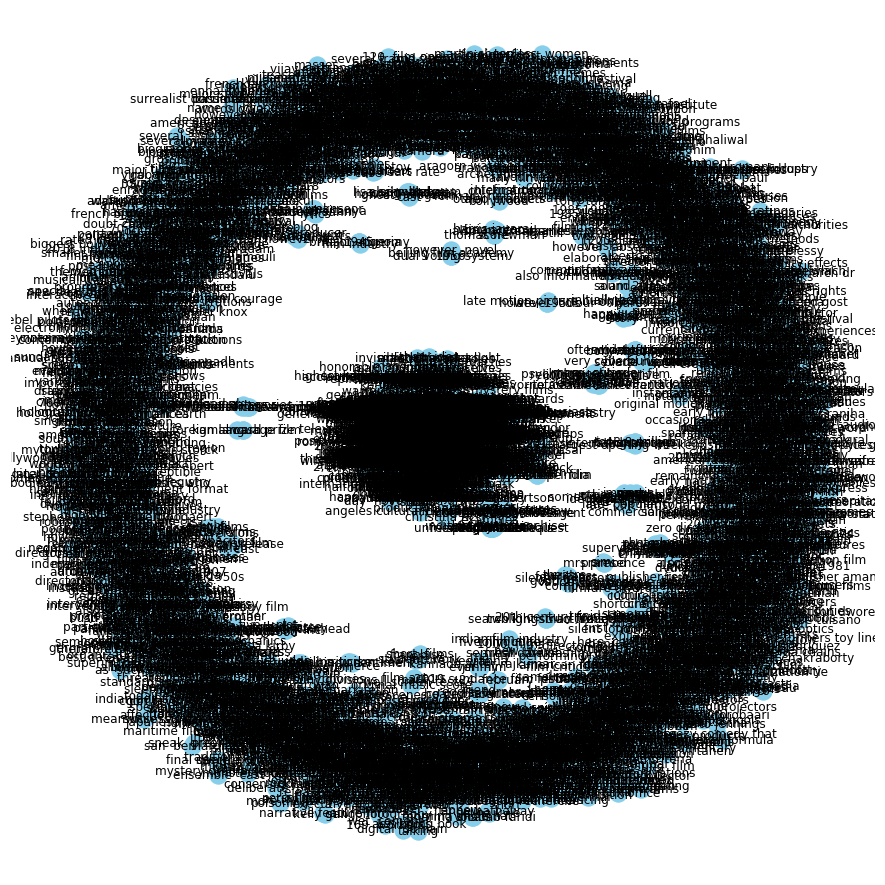

In [28]:
plt.figure(figsize=(12, 12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos=pos)
plt.show()

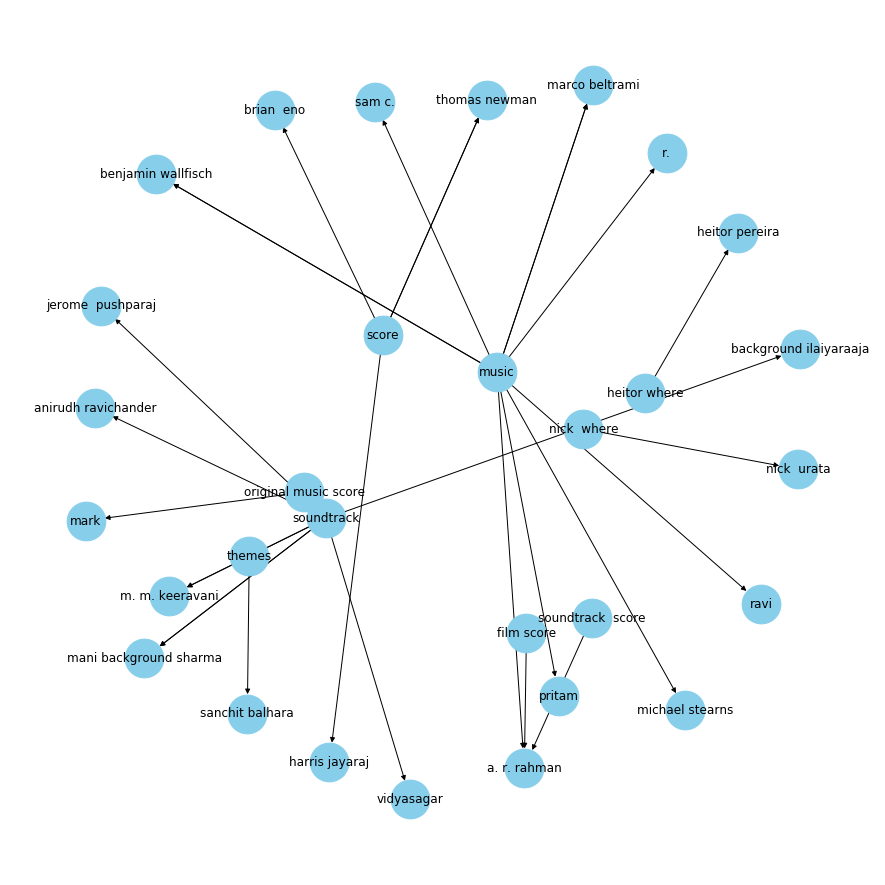

In [31]:
G = nx.from_pandas_edgelist(kg_df[kg_df['edge']=='composed by'], 'source', 'target',
                            edge_attr=True, create_using=nx.MultiDiGraph())
                            
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos=pos)
plt.show()



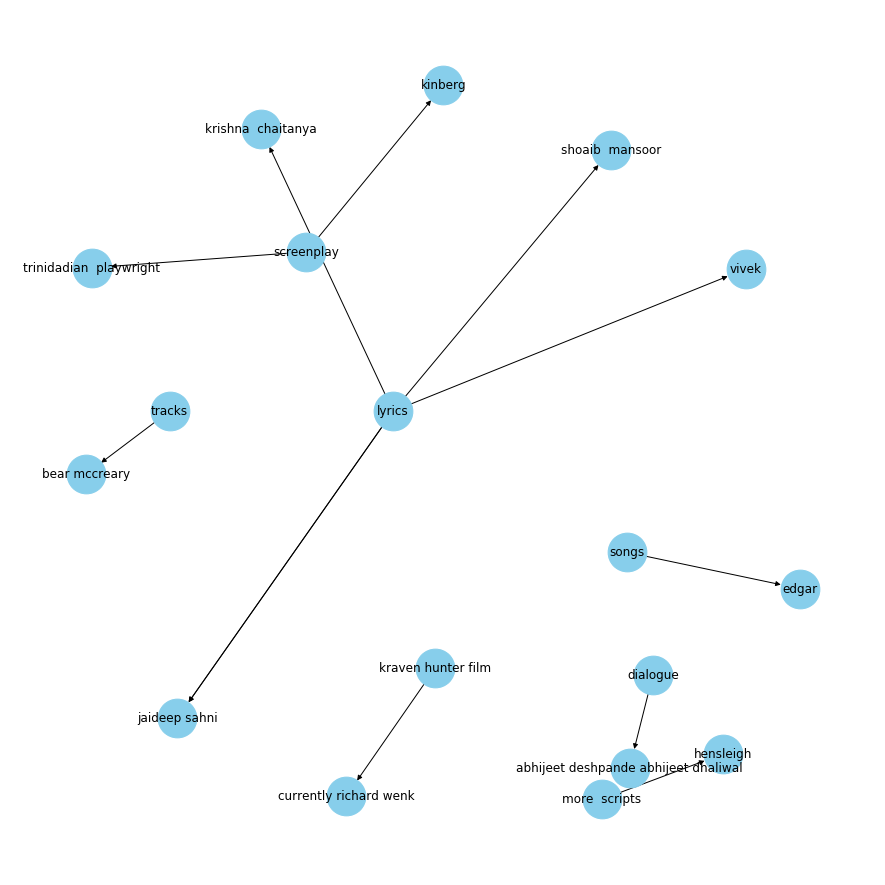

In [32]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=='written by'], 'source', 'target',
                        edge_attr=True, create_using=nx.MultiDiGraph())
plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k=0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos=pos)
plt.show()

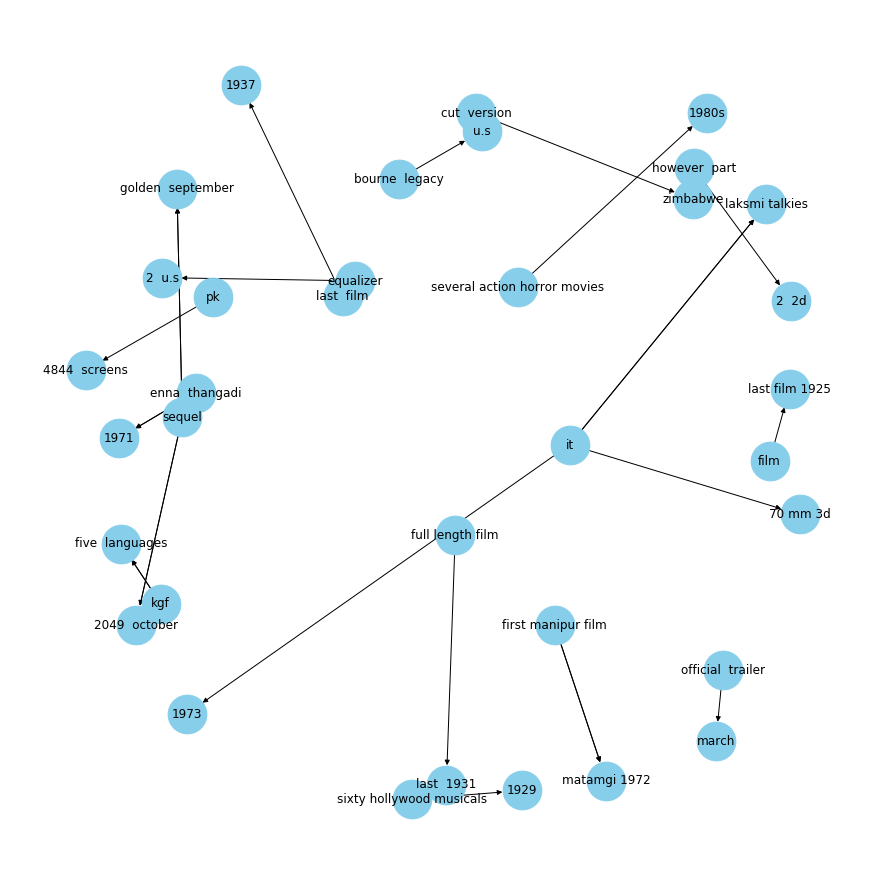

In [33]:
G = nx.from_pandas_edgelist(kg_df[kg_df['edge']=='released in'], 'source', 'target',
                           edge_attr=True, create_using=nx.MultiDiGraph())
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos=pos)
plt.show()